# 支撑位

In [37]:
# 获取数据源
import baostock as bs
import pandas as pd
import logging
import numpy as np

def get_k_data(code, start, end):
    lg = bs.login()
    # 显示登陆返回信息
    logging.info('login respond error_code:' + lg.error_code)
    logging.info('login respond  error_msg:' + lg.error_msg)
    # 获取股票数据
    rs = bs.query_history_k_data_plus(code,
                                              "date,open,high,low,close,volume",
                                              start_date=start,
                                              end_date=end,
                                              frequency="d",
                                              adjustflag="3")  # adjustflag="3"表示不复权
    data = rs.get_data()


    # 登出baostock系统
    bs.logout()

    # 创建DataFrame
    df = data[['date', 'open', 'high', 'low', 'close', 'volume']].rename(columns={'date': 'Date'})

    # 转换日期格式
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)  # 设置日期列为索引

    # 将空字符串替换为 NaN
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].replace('', np.nan)
    # 去除包含空值的行
    df = df.dropna(subset=['open', 'high', 'low', 'close', 'volume'])

    # 将股价数据转换为数值类型
    df[['open', 'high', 'low', 'close', 'volume']] = df[['open', 'high', 'low', 'close', 'volume']].astype(float)
    return df


In [38]:
stock_code = "sh.603486"  # 沪深300
start_date = "2024-01-01"
end_date = "2025-12-31"

df = get_k_data(stock_code, start_date, end_date)

login success!
logout success!


In [39]:
import scipy as sp
import mplfinance as mpf
import numpy as np
from scipy.signal import find_peaks


df = df.tail(180) 

# 定义强峰值的距离（天数）
strong_peak_distance = 60   #例如，60天

# 定义强峰值的显著性（prominence）
strong_peak_prominence = 20 #显著性阈值

# 找到'高'价格数据中的强峰值
strong_peaks, _ = find_peaks(df['high'], distance=strong_peak_distance, prominence=strong_peak_prominence)

# 提取强峰值的对应高值
strong_peaks_values = df.iloc[strong_peaks]['high'].tolist()

# 包括52周最高价作为额外的强峰值
yearly_high = df['high'].iloc[-252:].max()
strong_peaks_values.append(yearly_high)


print("强峰值（阻力位）:", strong_peaks_values)

# 找到'低'价格数据中的强谷值
strong_troughs, _ = find_peaks(-df['low'], distance=strong_peak_distance, prominence=strong_peak_prominence)

# 提取强谷值的对应低值
strong_troughs_values = df.iloc[strong_troughs]['low'].tolist()

# 包括52周最低价作为额外的强谷值
yearly_low = df['low'].iloc[-252:].min()
strong_troughs_values.append(yearly_low)

print("强谷值（支撑位）:", strong_troughs_values)

强峰值（阻力位）: [62.7]
强谷值（支撑位）: [36.25]


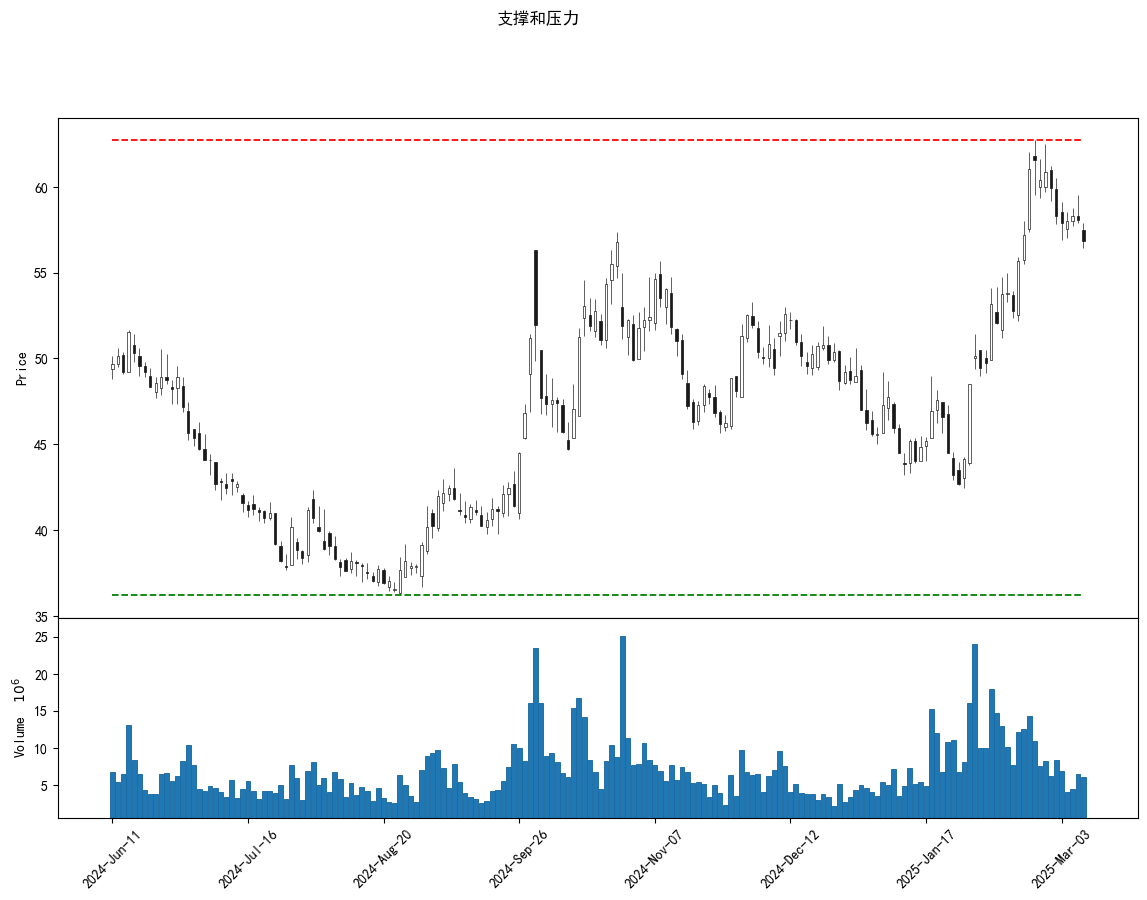

In [40]:




# 创建一个列表，包含水平线以绘制为阻力位
add_plot_resistance = [mpf.make_addplot(np.full(len(df), resistance), color='r', linestyle='--') for resistance in strong_peaks_values]

# 创建一个列表包含水平线以绘制为支撑位
add_plot_support = [mpf.make_addplot(np.full(len(df), support), color='g', linestyle='--') for support in strong_troughs_values]

aps = add_plot_resistance + add_plot_support


# 创建自定义风格，设置中文字体
my_style = mpf.make_mpf_style(rc={'font.sans-serif': ['SimHei'],
                                  'axes.unicode_minus': False})


# 绘制包含强阻力位的蜡烛图
mpf.plot(df, type='candle', style=my_style, title='支撑和压力', volume=True, addplot=aps,figsize=(15,10))
